# Tahu lah apa ini?

In [53]:
# Path to google drive folder
# %cd /content/drive/MyDrive/Colab Notebooks/Disertasi-Ahmad-Rofiqul/002. Laporan-eksperimen
# %cd /content/drive/MyDrive/Colab Notebooks/Disertasi-Ahmad-Rofiqul/002.Experiment_SWI_16052024/

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest, VotingClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from pyod.models.hbos import HBOS
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, OutlierMixin
from scipy.spatial.distance import mahalanobis

In [55]:
# Load the dataset
# file_path = '01.Dataset-Rofiqul/agriculture_dataset.csv'
# file_path = '01.Dataset-Rofiqul/Ujicoba3-29052024/agriculture_dataset.csv'
# file_path = 'dataset/agriculture_dataset.csv'
# file_path = 'dataset/09_05_1_AgricultureOutliersResult_30052024.csv'
# file_path = 'dataset/09_05_3_0_AgricultureOutliersDetectionResults.csv'
# file_path = 'dataset/09_05_3_2_AgricultureOutliersVotingBasedResult.csv'
file_path = 'dataset/09_05_4_1_AgricultureOutliers_HardVotingBased_IDO_Update10082024.csv'
data= pd.read_csv(file_path)




In [56]:
data

,Date,Year,Experiment,DataUse,Replication,Month,Vegetation,VegType,N2O,N_rate,...,NO3,Clay,Sand,SOM,if_outlier,dbscan_outlier,ocsvm_outlier,majority_voting,soft_voting,weighted_voting
0,2/9/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.896742,170,...,22.940812,62.500000,637.500000,1.174072,1,1,1,1,1,1
1,2/10/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,2.190218,170,...,22.959578,62.500000,637.500000,1.174072,1,1,1,1,1,1
2,2/18/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.542594,170,...,23.221928,62.500000,637.500000,1.174072,1,1,1,1,1,1
3,2/19/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.342870,170,...,23.271978,62.500000,637.500000,1.174072,1,1,1,1,1,1
4,3/16/12,2012,BCSE_KBS,Building,R1,March,Corn,Annual,2.947778,170,...,24.206855,62.500000,637.500000,1.174072,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2067,10/16/2013,2013,MCSE-T2,Testing,R4,October,TRIAE,Annual,1.640000,91,...,5.803681,128.333333,491.666667,1.806000,1,1,1,1,1,1
2068,11/15/2013,2013,MCSE-T2,Testing,R1,November,TRIAE,Annual,0.990000,91,...,5.429873,162.500000,490.375000,1.496400,1,1,1,1,1,1
2069,11/15/2013,2013,MCSE-T2,Testing,R2,November,TRIAE,Annual,-0.200000,91,...,7.239000,183.250000,432.875000,1.186800,1,1,1,1,1,1
2070,11/15/2013,2013,MCSE-T2,Testing,R3,November,TRIAE,Annual,0.300000,91,...,8.434294,169.833333,418.833333,1.823200,1,1,1,1,1,1


In [57]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt
import seaborn as sns


In [58]:
hard=data[data['majority_voting']==1]
soft=data[data['soft_voting']==1]

In [59]:
# Count the number of outliers and non-outliers for each voting method
hard_outlier_count = hard[hard['majority_voting'] == -1].shape[0]
hard_non_outlier_count = hard[hard['majority_voting'] == 1].shape[0]

soft_outlier_count = soft[soft['soft_voting'] == -1].shape[0]
soft_non_outlier_count = soft[soft['soft_voting'] == 1].shape[0]
print(f"Hard Voting - Number of outliers: {hard_outlier_count}")
print(f"Hard Voting - Number of non-outliers: {hard_non_outlier_count}")

print(f"Soft Voting - Number of outliers: {soft_outlier_count}")
print(f"Soft Voting - Number of non-outliers: {soft_non_outlier_count}")

Hard Voting - Number of outliers: 0
Hard Voting - Number of non-outliers: 2072
Soft Voting - Number of outliers: 0
Soft Voting - Number of non-outliers: 2072


## Prepare Train Test Split

In [60]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor, DMatrix, cv
import matplotlib.pyplot as plt
import seaborn as sns


In [61]:
# Preprocess the data
features = hard.drop(columns=['N2O'])  # Assuming 'N2O' is the target column
target = hard['N2O']

# Encode categorical variables if any
label_encoders = {}
for column in features.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    features[column] = label_encoders[column].fit_transform(features[column])

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Define X and y
X = scaled_features
y = target

In [62]:
# Function to evaluate the model
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

# Function to perform no cross-validation
def no_cross_validation(X_train, y_train, X_test, y_test):
    model = XGBRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return evaluate_model(y_test, y_pred)

# Function to perform sklearn cross_val_score
def sklearn_cross_val_score(X, y):
    model = XGBRegressor()
    mae = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error').mean()
    mse = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error').mean()
    rmse = np.sqrt(mse)
    r2 = cross_val_score(model, X, y, cv=5, scoring='r2').mean()
    return mae, mse, rmse, r2

# Function to perform xgb.cv
def xgb_cv(X, y):
    dtrain = DMatrix(X, label=y)
    params = {
        'objective': 'reg:squarederror',
        'max_depth': 5,
        'eta': 0.1,
        # 'silent': 1
    }
    cv_results = cv(params, dtrain, num_boost_round=100, nfold=5, metrics=['mae', 'rmse'], early_stopping_rounds=10, seed=42)
    mae = cv_results['test-mae-mean'].iloc[-1]
    rmse = cv_results['test-rmse-mean'].iloc[-1]
    mse = rmse ** 2
    # Calculate R-Squared
    r2 = 1 - (mse / np.var(y))
    return mae, mse, rmse, r2

In [63]:
# Function to perform testing for a given test size
def perform_testing(X, y, test_size):
    results = {'Test Size': [], 'Method': [], 'MAE': [], 'MSE': [], 'RMSE': [], 'R2': []}
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # No Cross Validation
    mae, mse, rmse, r2 = no_cross_validation(X_train, y_train, X_test, y_test)
    results['Test Size'].append(test_size)
    results['Method'].append('No CV')
    results['MAE'].append(mae)
    results['MSE'].append(mse)
    results['RMSE'].append(rmse)
    results['R2'].append(r2)

    # Sklearn cross_val_score
    mae, mse, rmse, r2 = sklearn_cross_val_score(X, y)
    results['Test Size'].append(test_size)
    results['Method'].append('Sklearn cv')
    results['MAE'].append(mae)
    results['MSE'].append(mse)
    results['RMSE'].append(rmse)
    results['R2'].append(r2)
    
    # xgb.cv
    mae, mse, rmse, r2 = xgb_cv(X, y)
    results['Test Size'].append(test_size)
    results['Method'].append('xgb.cv')
    results['MAE'].append(mae)
    results['MSE'].append(mse)
    results['RMSE'].append(rmse)
    results['R2'].append(r2)
    
    return results

In [64]:
test_sizes = [0.2, 0.25, 0.3, 0.35]
all_results = []

for test_size in test_sizes:
    results = perform_testing(X, y, test_size)
    all_results.append(pd.DataFrame(results))

In [65]:
# Combine all results into a single DataFrame
final_results_df = pd.concat(all_results, ignore_index=True)
final_results_df

,Test Size,Method,MAE,MSE,RMSE,R2
0,0.20,No CV,1.723013,6.446511,2.538998,0.643607
1,0.20,Sklearn cv,2.670104,13.242584,3.639036,0.212611
2,0.20,xgb.cv,1.772720,6.354490,2.520811,0.636342
3,0.25,No CV,1.815353,6.870350,2.621135,0.607467
4,0.25,Sklearn cv,2.670104,13.242584,3.639036,0.212611
5,0.25,xgb.cv,1.772720,6.354490,2.520811,0.636342
6,0.30,No CV,1.745491,6.444761,2.538653,0.614603
7,0.30,Sklearn cv,2.670104,13.242584,3.639036,0.212611
8,0.30,xgb.cv,1.772720,6.354490,2.520811,0.636342
9,0.35,No CV,1.818596,6.976571,2.641320,0.569086


In [68]:
final_results_df.to_csv('dataset/0906_2_xgboost_eval_results_nooutliers_IDO_noregulator_nostandardscaler_Update10082024.csv', index=False)


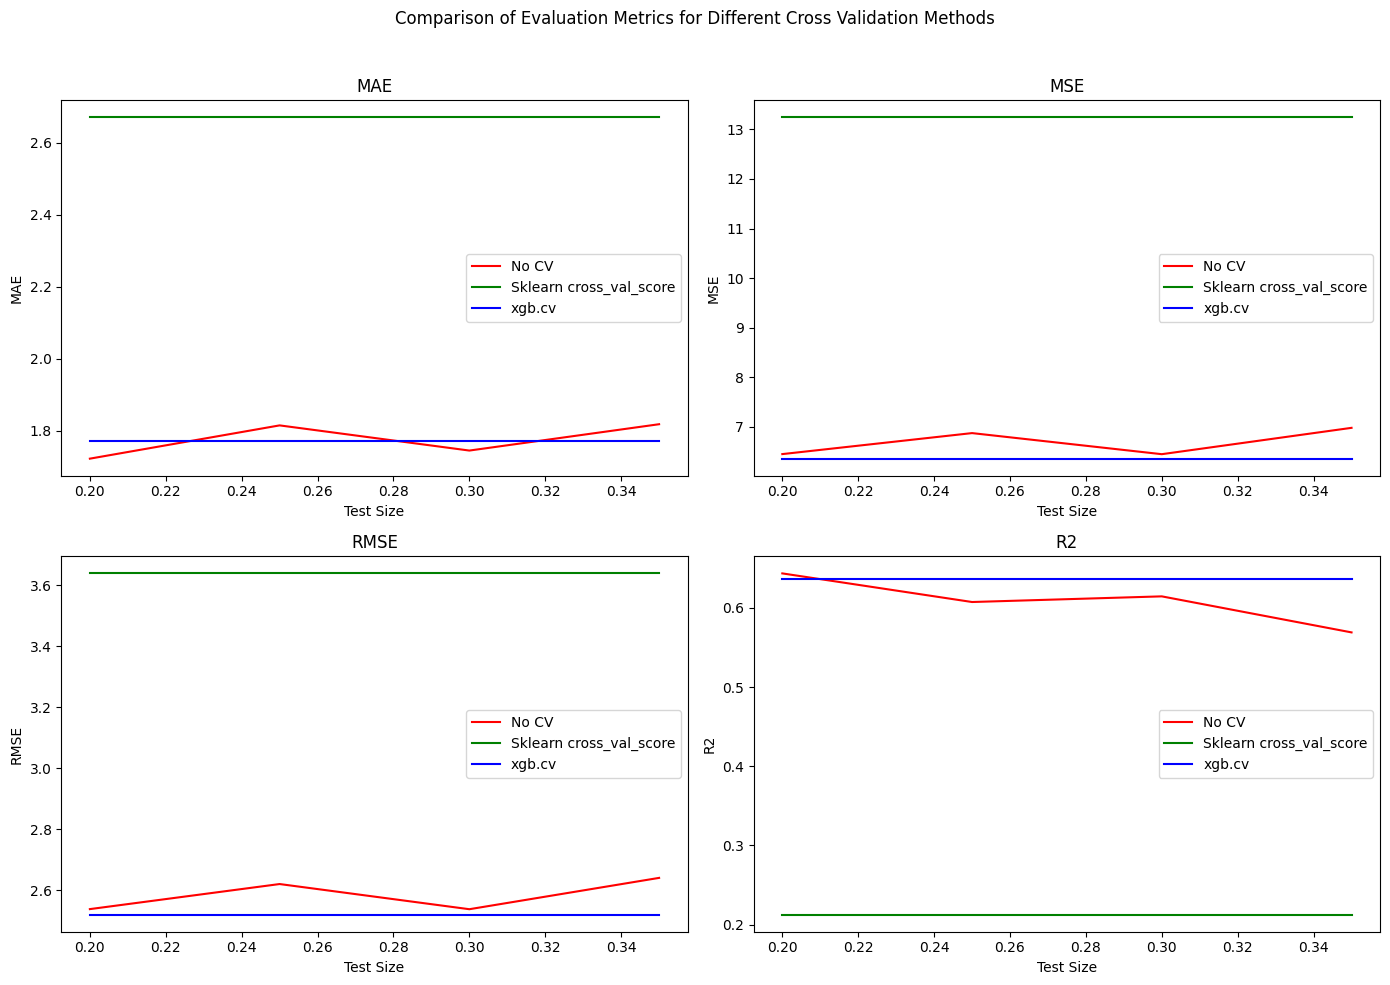

In [27]:
# Plotting the results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Comparison of Evaluation Metrics for Different Cross Validation Methods')

metrics = ['MAE', 'MSE', 'RMSE', 'R2']
methods = ['No CV', 'Sklearn cross_val_score', 'xgb.cv']
colors = ['r', 'g', 'b']

for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]
    for j, method in enumerate(methods):
        method_df = final_results_df[final_results_df['Method'] == method]
        ax.plot(method_df['Test Size'], method_df[metric], label=method, color=colors[j])
    ax.set_title(metric)
    ax.set_xlabel('Test Size')
    ax.set_ylabel(metric)
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

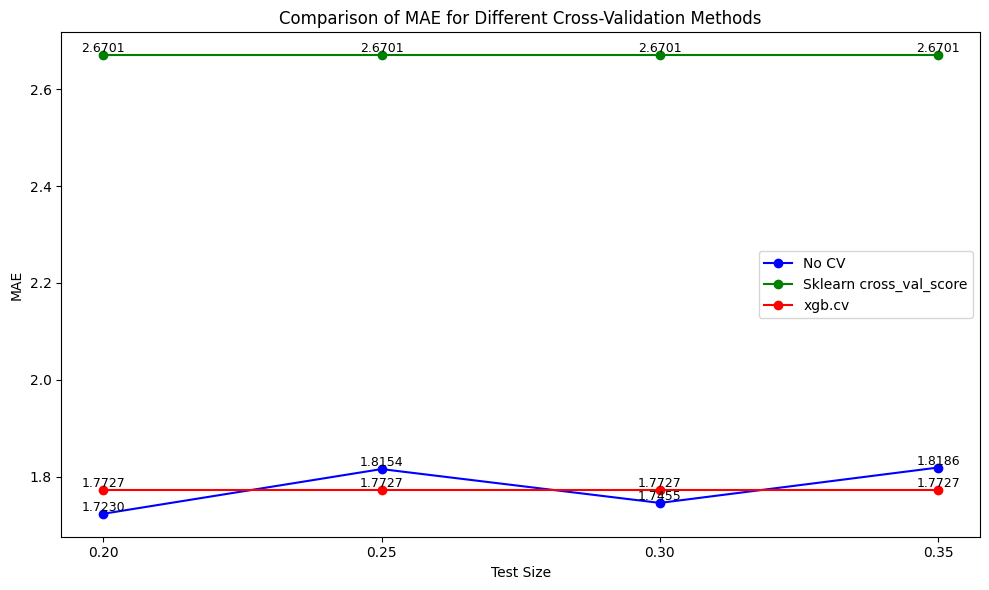

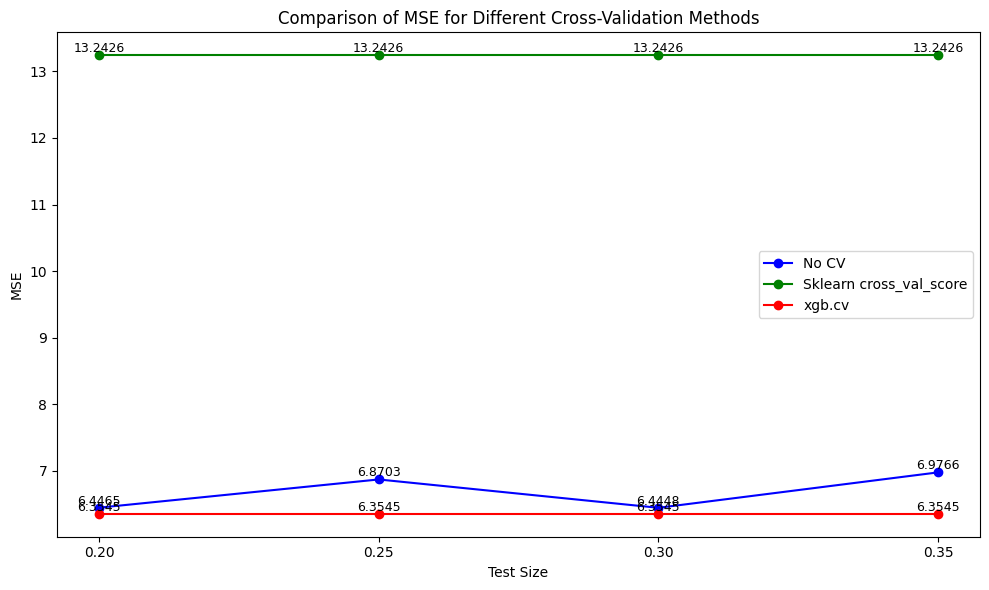

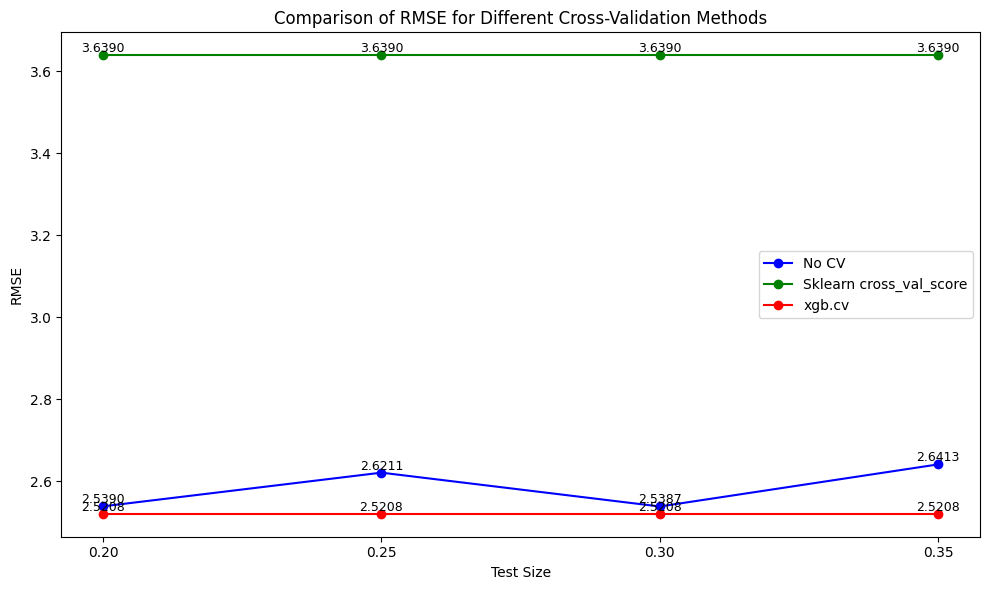

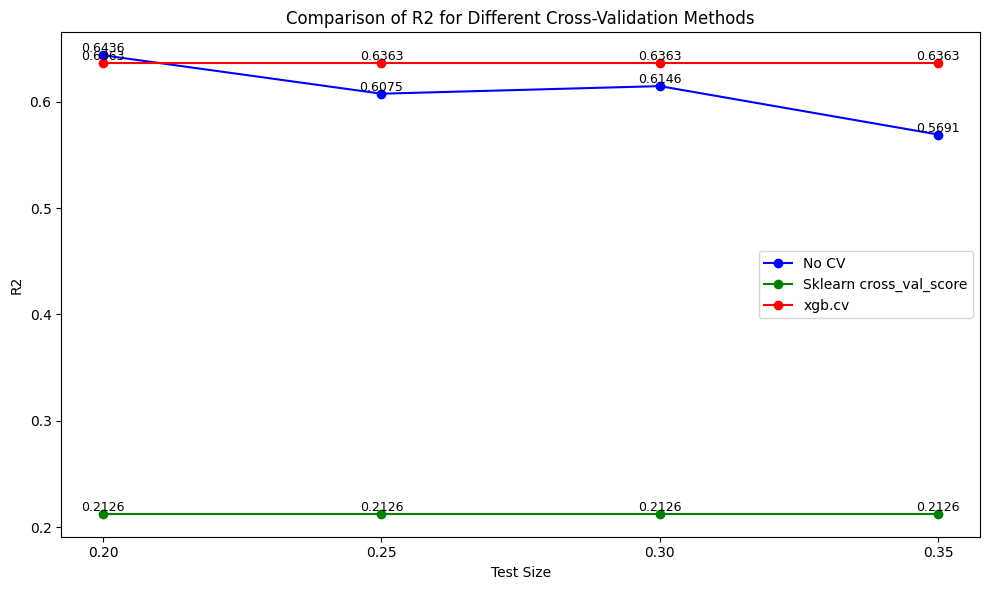

In [32]:
# Visualization
metrics = ['MAE', 'MSE', 'RMSE', 'R2']
methods = final_results_df['Method'].unique()
colors = ['b', 'g', 'r']  # Adjust or expand this list as needed

for metric in metrics:
    plt.figure(figsize=(10, 6))
    for i, method in enumerate(methods):
        subset = final_results_df[final_results_df['Method'] == method]
        plt.plot(subset['Test Size'], subset[metric], marker='o', label=method, color=colors[i % len(colors)])
        
        for x, y in zip(subset['Test Size'], subset[metric]):
            plt.text(x, y, f'{y:.4f}', ha='center', va='bottom', fontsize=9)

    plt.xlabel('Test Size')
    plt.ylabel(metric)
    plt.title(f'Comparison of {metric} for Different Cross-Validation Methods')
    plt.xticks(test_sizes)
    plt.legend()
    plt.tight_layout()
    plt.show()


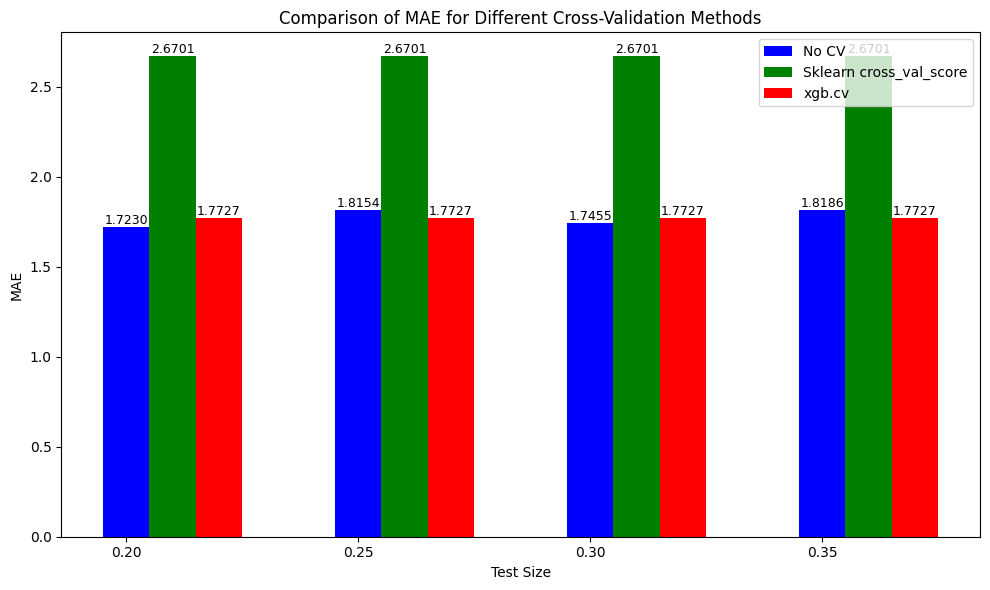

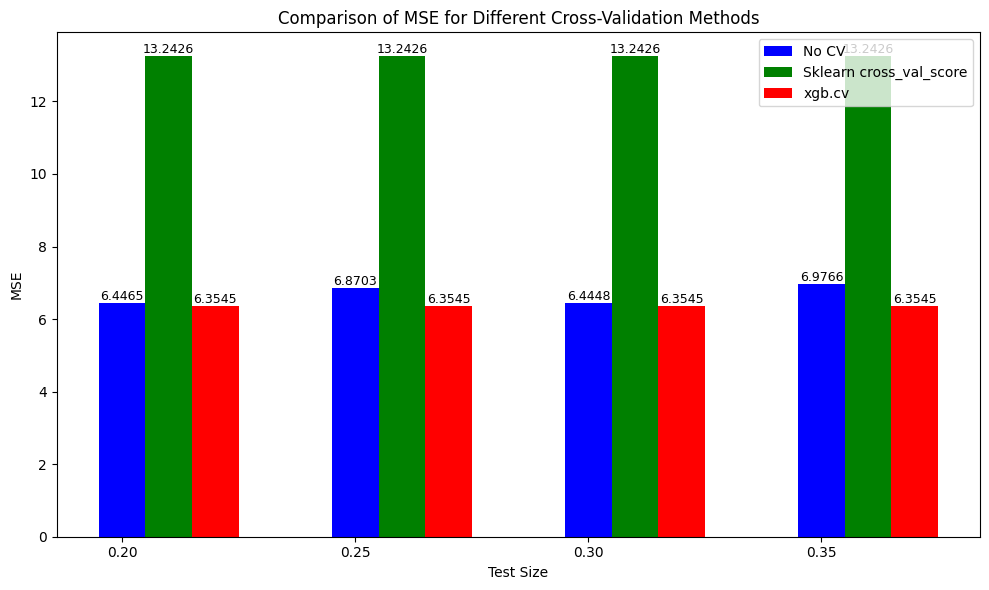

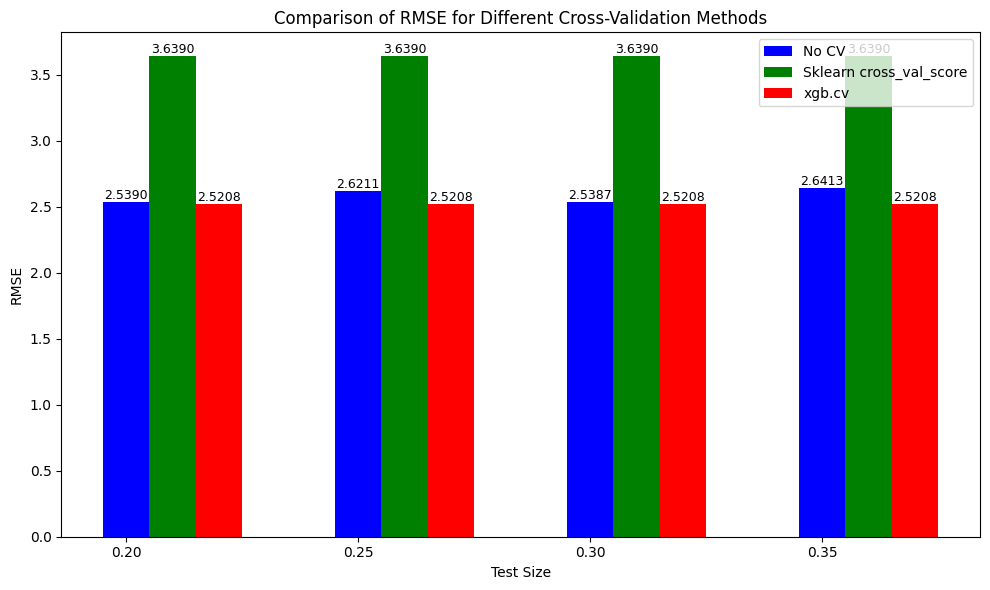

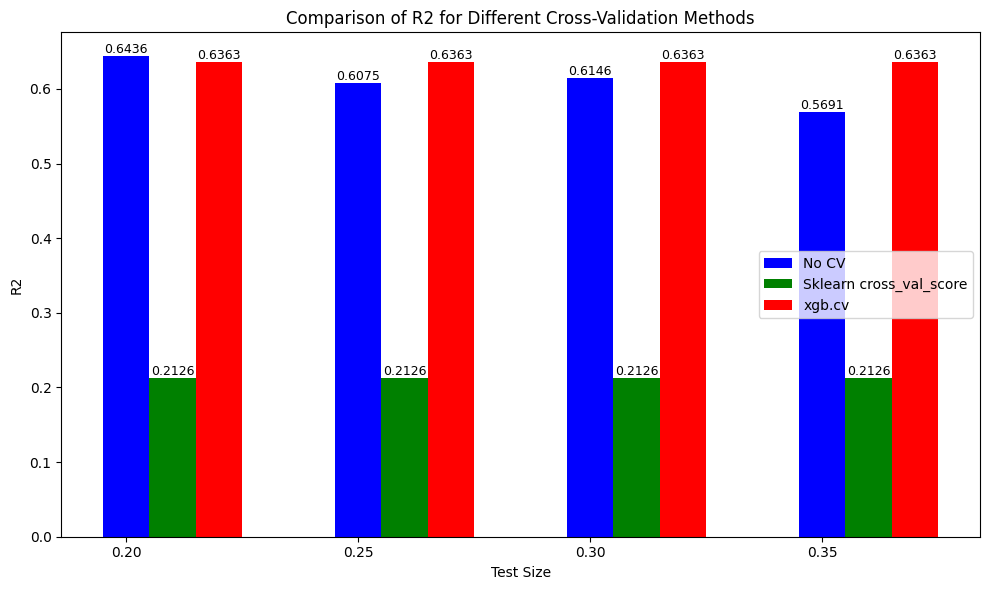

In [31]:
# Visualization
metrics = ['MAE', 'MSE', 'RMSE', 'R2']
methods = final_results_df['Method'].unique()
colors = ['b', 'g', 'r']  # Adjust or expand this list as needed

for metric in metrics:
    plt.figure(figsize=(10, 6))
    bar_width = 0.01  # Increase the bar width
    for i, method in enumerate(methods):
        subset = final_results_df[final_results_df['Method'] == method]
        plt.bar(subset['Test Size'] + i * bar_width, subset[metric], width=bar_width, label=method, color=colors[i % len(colors)])
        
        for x, y in zip(subset['Test Size'], subset[metric]):
            plt.text(x + i * bar_width, y, f'{y:.4f}', ha='center', va='bottom', fontsize=9)

    plt.xlabel('Test Size')
    plt.ylabel(metric)
    plt.title(f'Comparison of {metric} for Different Cross-Validation Methods')
    plt.xticks(test_sizes)
    plt.legend()
    plt.tight_layout()
    plt.show()


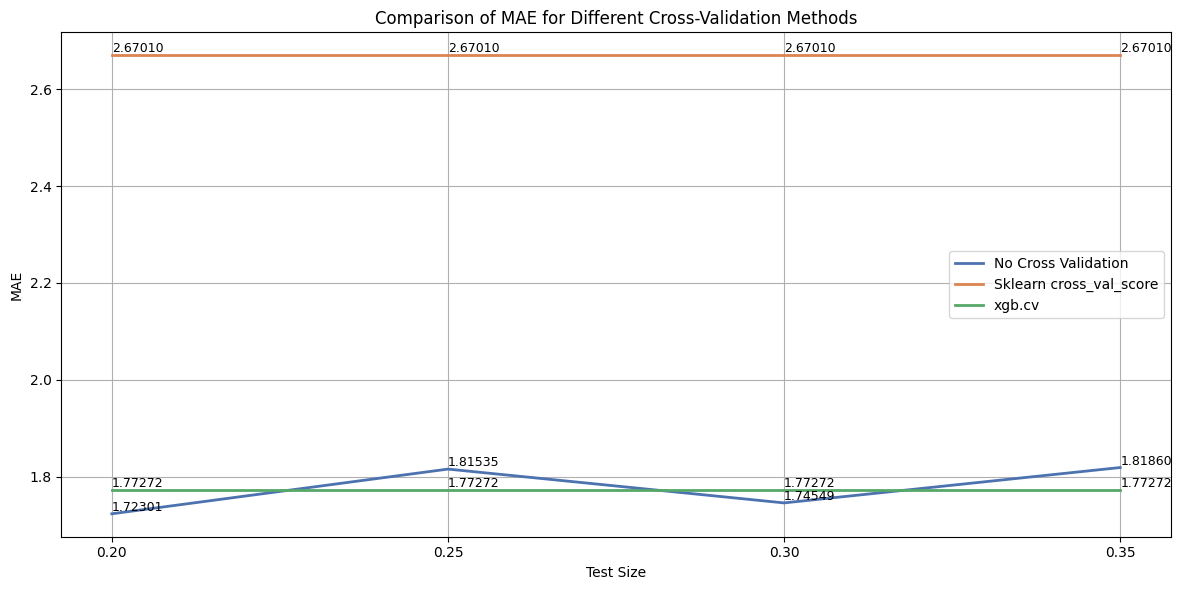

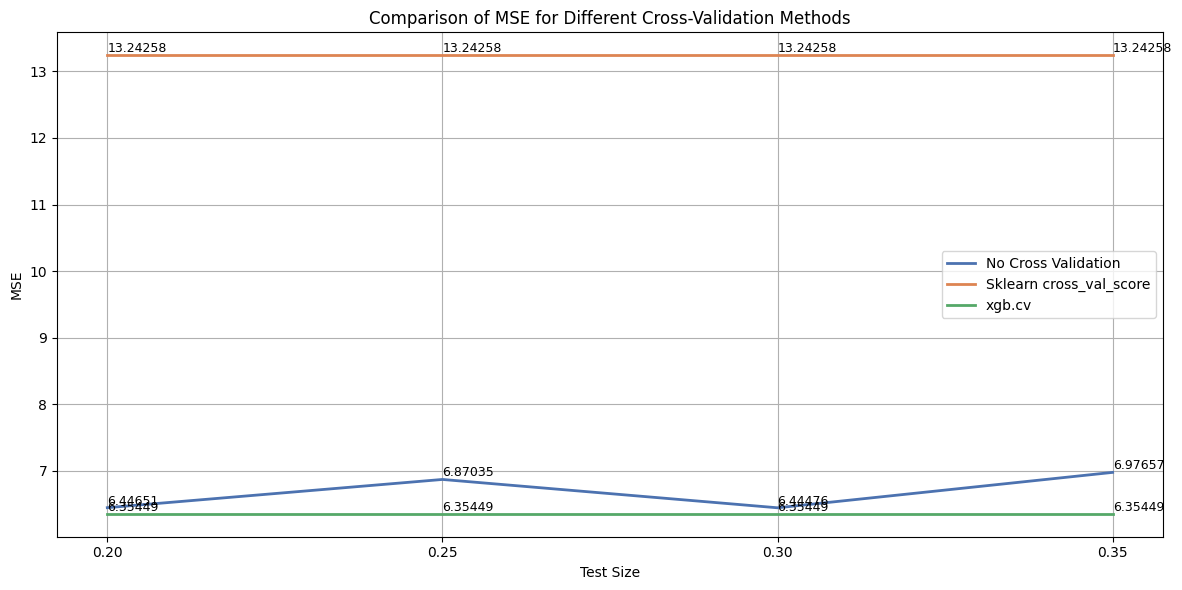

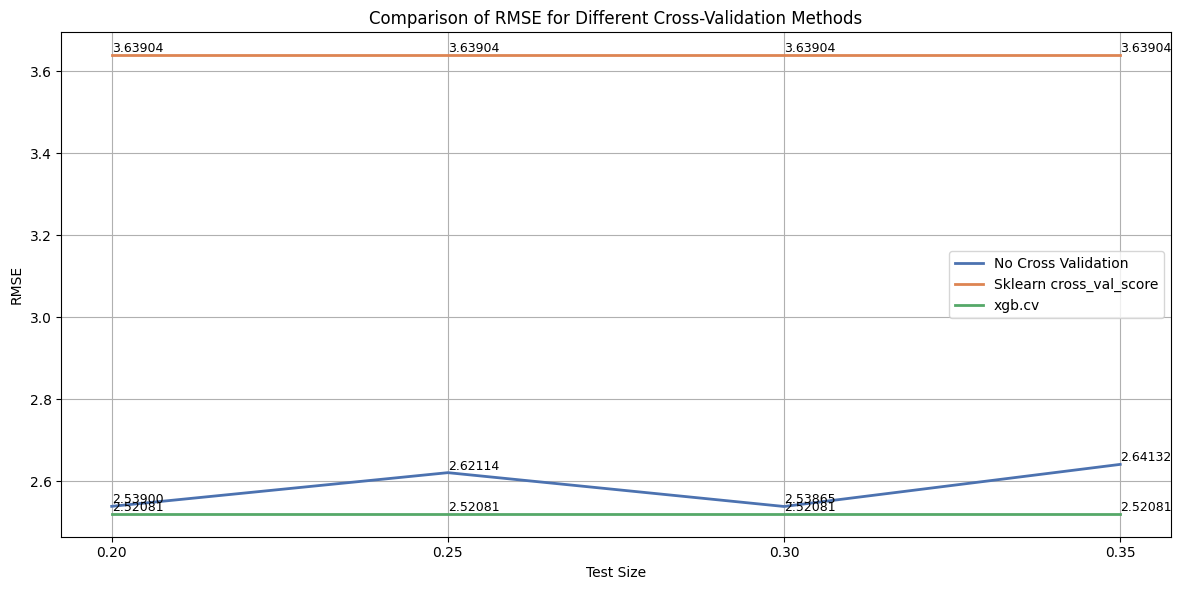

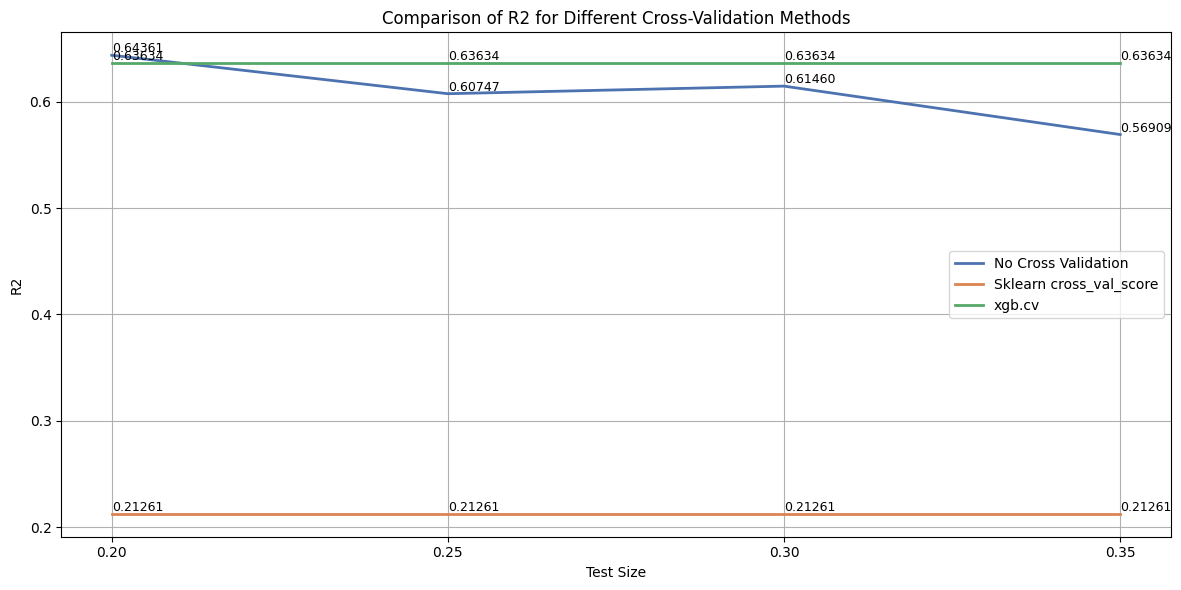

In [27]:
metrics = ['MAE', 'MSE', 'RMSE', 'R2']
methods = final_results_df['Method'].unique()
palette = sns.color_palette("deep", len(methods))  # Use a more visually appealing color palette

for metric in metrics:
    plt.figure(figsize=(12, 6))
    
    for i, method in enumerate(methods):
        subset = final_results_df[final_results_df['Method'] == method]
        plt.plot(subset['Test Size'], subset[metric], label=method, color=palette[i], linewidth=2)
        
        for j, (_, row) in enumerate(subset.iterrows()):
            plt.text(row['Test Size'], row[metric], f'{row[metric]:.5f}', ha='left', va='bottom', fontsize=9)
    
    plt.xlabel('Test Size')
    plt.ylabel(metric)
    plt.title(f'Comparison of {metric} for Different Cross-Validation Methods')
    plt.xticks(test_sizes)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()